## Neural Style Transfer
---------------------------------------


Реализуем идею описанную в этой статье http://cs231n.stanford.edu/reports/2017/pdfs/416.pdf  
Сначала применим сегментацию к изображению, чтобы выделить объект на фото, потом по полученной маске применим 2 стиля: один к объекту, второй к фону.

Загрузим необходимые библиотеки и подключим Google disk:

In [ ]:
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import copy
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Images")
!ls

 1910-8.jpg		    img1.jpg   person1.jpg   starry_night.jpg
'black-&-white-cover.jpg'   lisa.jpg   person2.jpg   style_0.jpg
 dancing.jpg		    mask.jpg   picasso.jpg   style_1.jpg


**Загрузка изображений**

Нам понадобятся 2 картинки стиля и 1 контента, так что загрузим их.<br />

In [ ]:
imsize = 512 

loader = transforms.Compose([
    transforms.Resize(imsize),  
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style1_img = image_loader("/content/drive/My Drive/Colab Notebooks/Images/picasso.jpg") 
style2_img = image_loader("/content/drive/My Drive/Colab Notebooks/Images/style_1.jpg")
content_img = image_loader("/content/drive/My Drive/Colab Notebooks/Images/person1.jpg") 

Выведем то, что было загружено

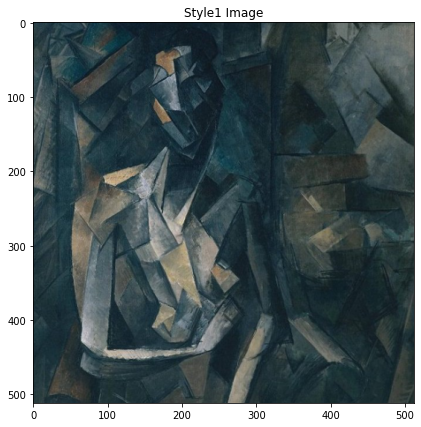

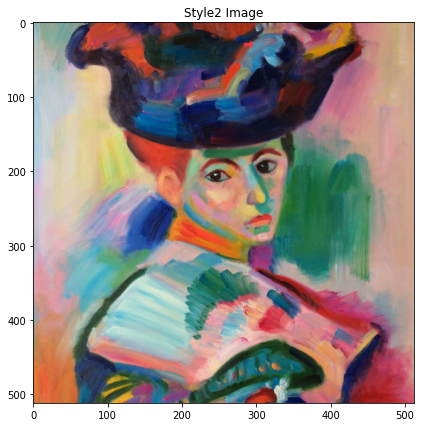

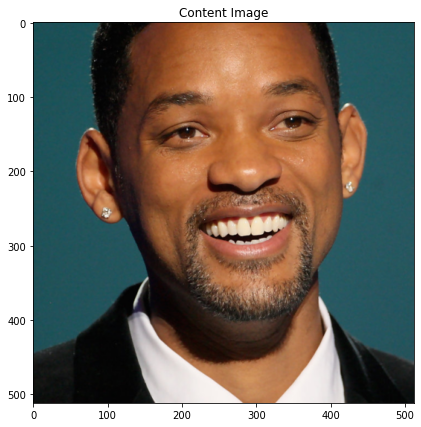

In [ ]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None, cmap=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure(figsize=(7,7))
imshow(style1_img, title='Style1 Image')

plt.figure(figsize=(7,7))
imshow(style2_img, title='Style2 Image')

plt.figure(figsize=(7,7))
imshow(content_img, title='Content Image')

## Сегментация
Загрузим предобученную на COCO датасете модель FCN ResNet50 (20 классов):   
['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
model = models.segmentation.fcn_resnet50(pretrained=True).eval().to(device)

Карта отрисовки лейблов объектов:

In [ ]:
label_map = [
               (255, 255, 255),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus 
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
]

Нормализация под COCO dataset:

In [ ]:
transform = transforms.Compose([
    transforms.Resize(imsize),  
    transforms.CenterCrop(imsize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
def get_segment_labels(path, model, device):
    image = Image.open(path)
    image = transform(image).unsqueeze(0).to(device)
    outputs = model(image)
    return outputs

Функция для отрисовки сегментированного изображения:

In [ ]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)
    
    for label_num in range(0, len(label_map)):
        index = labels == label_num
        red_map[index] = np.array(label_map)[label_num, 0]
        green_map[index] = np.array(label_map)[label_num, 1]
        blue_map[index] = np.array(label_map)[label_num, 2]
        
    segmented_image = np.stack([red_map, green_map, blue_map], axis=2)
    return segmented_image

Получим вывод модели и сегментацию:

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Images/person1.jpg"

outputs = get_segment_labels(path, model, device)
outputs = outputs['out']
segmented_image = draw_segmentation_map(outputs)

Отрисовка и сохранение маски:

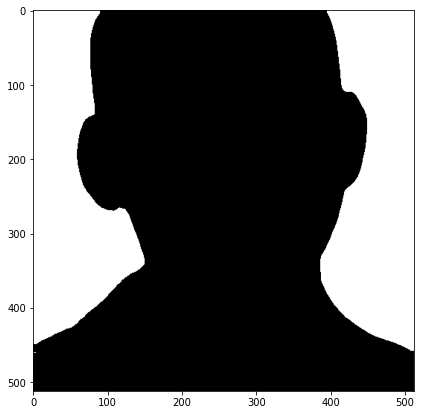

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(segmented_image[:,:,0], cmap='gray')

plt.imsave('mask.jpg', segmented_image[:,:,0], cmap='gray')
plt.show()

Загрузим маску, приведем к формату контента и стилей, оставим только 1 канал из 3:

In [ ]:
mask_img = image_loader("/content/drive/My Drive/Colab Notebooks/Images/mask.jpg")

In [ ]:
mask_img = mask_img[:,0,:,:].unsqueeze(0)

In [ ]:
mask_img.shape

torch.Size([1, 1, 512, 512])

# NST
Для переноса стиля будем использовать VGG19  
Определим предобученную модель

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ощибка input'а и target'а

In [ ]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach() #это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target ) #to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Матрица грама позволяет учесть не только сами значения feature map'а, но и кореляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич с друг другом, а не на их геометрическом положении. <br />

Таким образом:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем спрособ подсчета матрицы грама: Это просто тензорное тензорное произведение вектора выхода уровня самого на себя.<br /> Однако, наш выход - не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />

In [ ]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

Матрица грама готова, теперь нужно лишь реализовать MSE  
Поскольку у нас 2 стиля, получаем два лосса стилей. Реализуем их в forward.  
Граница разделения стилей идет по маски сегментации. Общий лосс складывается из обоих лоссов стиля.

In [ ]:
class StyleLoss(nn.Module):
        def __init__(self, target1_feature, target2_feature, mask_img):
            super(StyleLoss, self).__init__()
            self.target1 = gram_matrix(target1_feature).detach()
            self.target2 = gram_matrix(target2_feature).detach()
            self.mask_img = mask_img
            self.loss1 = F.mse_loss(self.target1, self.target1) # to initialize with something
            self.loss2 = F.mse_loss(self.target2, self.target2) 
        
        def forward(self, input):
            imsize = input.size()[2]
            loader = transforms.Resize(imsize)
            res_mask1 = loader(self.mask_img) > 0.5
            res_mask2 = loader(self.mask_img) < 0.5
            input1 = input * res_mask1
            input2 = input * res_mask2

            G1 = gram_matrix(input1)
            G2 = gram_matrix(input2)
            self.loss1 = F.mse_loss(G1, self.target1)
            self.loss2 = F.mse_loss(G2, self.target2)
            self.loss = self.loss1 + self.loss2
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Реалиазуем нормировку и для наших изображений тоже.


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Определим после каких уровней мы будем счиатать ошибки стиля, а после каких ошибки контента

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style1_img, style2_img, content_img, mask_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target1_feature = model(style1_img).detach()
                target2_feature = model(style2_img).detach()

                style_loss = StyleLoss(target1_feature, target2_feature, mask_img)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        # выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        # добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Дальше стандартный цикл обучения.  
Closure - это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style1_img, style2_img, mask_img, input_img, num_steps=300, #500
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style1_img, style2_img, content_img, mask_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                # взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Запуск обучения:

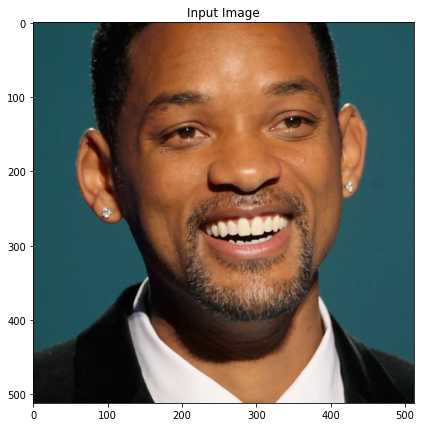

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 19.755873 Content Loss: 11.908963

run [100]:
Style Loss : 9.487332 Content Loss: 10.653575

run [150]:
Style Loss : 7.828588 Content Loss: 10.201228

run [200]:
Style Loss : 7.166418 Content Loss: 9.993773

run [250]:
Style Loss : 7.835580 Content Loss: 10.221121

run [300]:
Style Loss : 6.670418 Content Loss: 9.987919



In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure(figsize=(7,7))
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, mask_img, input_img)

Отрисовка и сохранение результата:

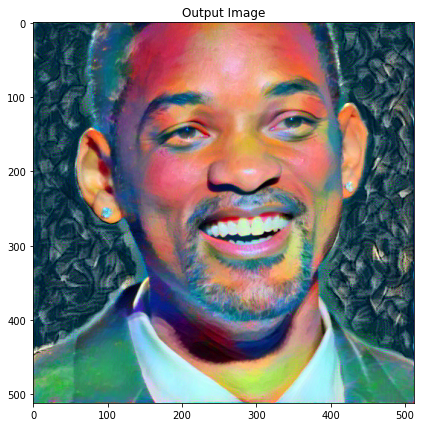

In [ ]:
plt.figure(figsize=(7,7))
imshow(output, title='Output Image')
save_image(output, 'img1.jpg')

plt.ioff()
plt.show()

Применим другие стили и другому контенту:

In [ ]:
style1_img = image_loader("/content/drive/My Drive/Colab Notebooks/Images/starry_night.jpg") 
style2_img = image_loader("/content/drive/My Drive/Colab Notebooks/Images/lisa.jpg")
content_img = image_loader("/content/drive/My Drive/Colab Notebooks/Images/person3.jpg") 

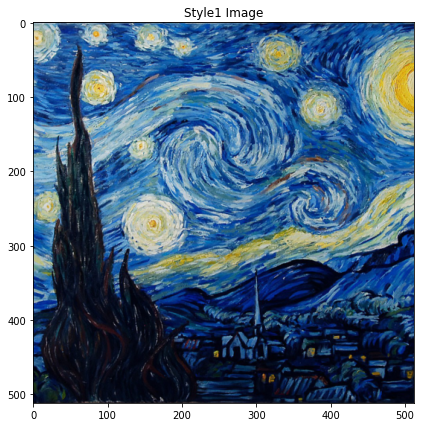

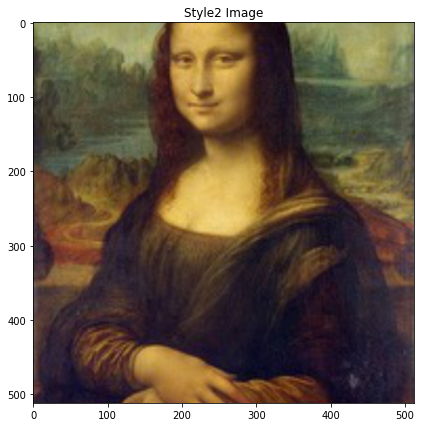

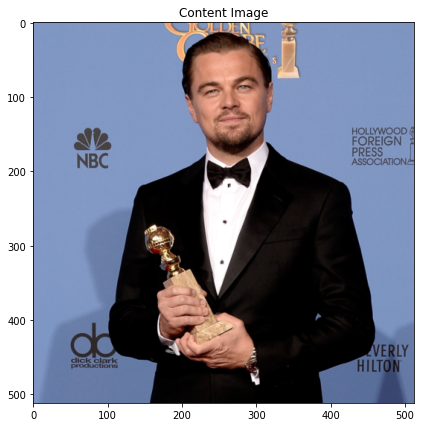

In [ ]:
plt.figure(figsize=(7,7))
imshow(style1_img, title='Style1 Image')

plt.figure(figsize=(7,7))
imshow(style2_img, title='Style2 Image')

plt.figure(figsize=(7,7))
imshow(content_img, title='Content Image')

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Images/person3.jpg"

outputs = get_segment_labels(path, model, device)
outputs = outputs['out']
segmented_image = draw_segmentation_map(outputs)

Отрисовка и сохранение маски:

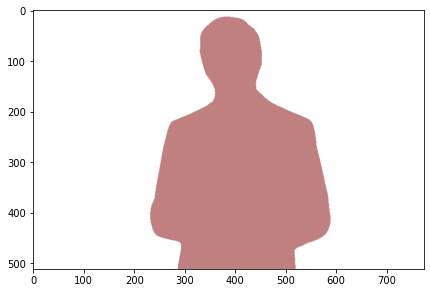

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(segmented_image)

plt.imsave('mask.jpg', segmented_image[:,:,0], cmap='gray')
plt.show()

Загрузим маску, приведем к формату контента и стилей, оставим только 1 канал из 3:

In [ ]:
mask_img = image_loader("/content/drive/My Drive/Colab Notebooks/Images/mask.jpg")

In [ ]:
mask_img = mask_img[:,0,:,:].unsqueeze(0)

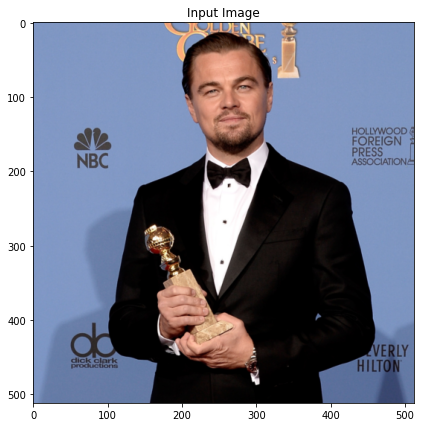

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 45.508274 Content Loss: 30.735415

run [100]:
Style Loss : 21.157000 Content Loss: 31.345814

run [150]:
Style Loss : 13.355499 Content Loss: 31.467031

run [200]:
Style Loss : 16.395515 Content Loss: 32.655094

run [250]:
Style Loss : 10.668264 Content Loss: 29.990967

run [300]:
Style Loss : 10.833241 Content Loss: 29.985733



In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure(figsize=(7,7))
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, mask_img, input_img)

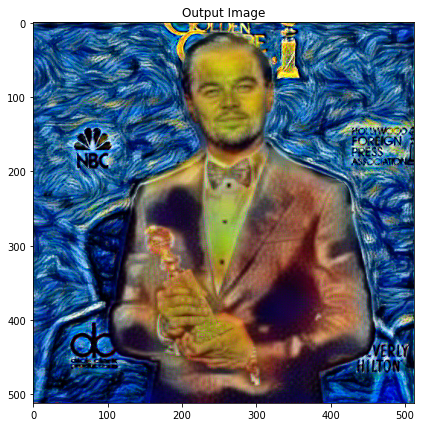

In [ ]:
plt.figure(figsize=(7,7))
imshow(output, title='Output Image')
save_image(output, 'img1.jpg')

plt.ioff()
plt.show()

## Вывод:
Архитектура взаимодействия двух моделей FCN ResNet50(сегментация) и VGG19(NST) позволяют выделять объекты и применять разные стили к объекту и фону. Что позволяет создавать интересные сочетания стилей на фотографии, причем количество вариантов бесконечно, в отличии от приложений в которых присутствует только определенное количество фильтров и не везде происходит сегментация объектов(как правило применяется фильтр(стиль) ко всей фотографии).  
Дальшейшее развитие - использовать все классы на изображении и к каждому применить свой уникальный стиль.